Miguel Conner

# knn and SVM Project Outline

We will follow the outline below. Essentially, I have explored the data and built features that help sepearate the two groups. Then, I created a pipeline that takes in the dataframe and does cross-validation on a number of parameters. 

1. Load Packages + Data
2. Data Exploration and Feature Engineering
    * Data Types and Histograms
    * Marital Status
    * Age **
    * Admission Hour
    * Diagnosis
    * Cancer
    * Comorbidity Count
    * ICU + Hospital Admission Counts
    * Ethnicity
    * Target Encode ICD9 Codes ** (from extra data set)
    * Other Miscellaneous Features
3. Trim Down Dataset
4. knn Pipeline
5. SVM Pipeline

# 1. Load Packages + Data

In [1]:
#Load packages
%matplotlib inline
import matplotlib.pylab as plt

#import auxiliar functions
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(os.path.dirname(currentdir))
sys.path.insert(1, parentdir)
from helper_functions import *

import pandas as pd
import seaborn as sns
import numpy as np
import sklearn
import category_encoders
from math import floor, ceil
import random

#import sys
#!{sys.executable} -m pip install sklearn

## Load Data

In [2]:
# Load the data
training = pd.read_csv('mimic_train.csv')
val = pd.read_csv('mimic_test_death.csv')

#Extra data
diag = pd.read_csv('MIMIC_metadata_diagnose.csv')
comorb = pd.read_csv('MIMIC_diagnoses.csv')
comorb['ICD9_CODE'] = comorb['ICD9_CODE'].astype(str)
#comorb['ICD9_CODE'] = [s.lstrip("0") for s in comorb['ICD9_CODE']]  
comorb['subject_id'] = comorb['SUBJECT_ID']

#Remove columns we can't use
training = training.drop(['DOD'], axis=1)
training = training.drop(['DISCHTIME'], axis=1)
training = training.drop(['DEATHTIME'], axis=1)
training = training.drop(['LOS'], axis=1)
training = training.drop(['Diff'], axis=1)
training['MARITAL_STATUS'] = training['MARITAL_STATUS'].fillna('UNKNOWN (DEFAULT)') #  <--- Some values are missing so combine NaN with already existing category

#perform training and test split
from sklearn.model_selection import train_test_split

X_tr = training
y_tr = training['HOSPITAL_EXPIRE_FLAG']
X_te = val

# Uncomment the command below to make out of sample tests.
#X_tr, X_te, y_tr, y_te = train_test_split(X_tr, y_tr, random_state=42)

# 2. Data Exploration + Feature Engineering

### Data Types and Histograms

In [3]:
X_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20885 entries, 0 to 20884
Data columns (total 39 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   HOSPITAL_EXPIRE_FLAG  20885 non-null  int64  
 1   subject_id            20885 non-null  int64  
 2   hadm_id               20885 non-null  int64  
 3   icustay_id            20885 non-null  int64  
 4   HeartRate_Min         18698 non-null  float64
 5   HeartRate_Max         18698 non-null  float64
 6   HeartRate_Mean        18698 non-null  float64
 7   SysBP_Min             18677 non-null  float64
 8   SysBP_Max             18677 non-null  float64
 9   SysBP_Mean            18677 non-null  float64
 10  DiasBP_Min            18676 non-null  float64
 11  DiasBP_Max            18676 non-null  float64
 12  DiasBP_Mean           18676 non-null  float64
 13  MeanBP_Min            18699 non-null  float64
 14  MeanBP_Max            18699 non-null  float64
 15  MeanBP_Mean        

In [4]:
X_tr.describe()

,HOSPITAL_EXPIRE_FLAG,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,...,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean
count,20885.000000,20885.000000,20885.000000,20885.000000,18698.000000,18698.000000,18698.000000,18677.000000,18677.000000,18677.000000,...,18696.000000,18388.000000,18388.000000,18388.000000,18682.000000,18682.000000,18682.000000,20632.000000,20632.000000,20632.000000
mean,0.112282,58950.496098,150082.402298,250202.495523,69.705904,105.239801,85.180250,91.110564,150.725920,119.145423,...,18.985855,36.051208,37.428781,36.751717,91.007494,99.555883,96.866685,106.781975,182.129604,138.856428
std,0.315720,25299.439535,28898.479845,28909.806302,14.869840,20.922613,15.318208,17.532534,23.833793,16.701503,...,3.849713,0.732124,0.799897,0.603476,7.399390,1.159792,2.333108,35.178811,92.665603,44.933145
min,0.000000,23.000000,100001.000000,200001.000000,2.000000,39.000000,34.714286,5.000000,46.000000,46.000000,...,9.291667,15.000000,30.800000,30.666667,1.000000,57.000000,47.666667,2.000000,42.000000,42.000000
25%,0.000000,41132.000000,125157.000000,225153.000000,60.000000,90.000000,74.272727,81.000000,134.000000,107.100000,...,16.250000,35.666667,36.944444,36.388889,90.000000,100.000000,95.812500,86.000000,126.000000,110.750000
50%,0.000000,60441.000000,150152.000000,250452.000000,69.000000,103.000000,84.131183,90.000000,148.000000,116.901961,...,18.382353,36.111111,37.333333,36.731481,92.000000,100.000000,97.142857,102.000000,161.000000,128.666667
75%,0.000000,80286.000000,175017.000000,275303.000000,79.000000,118.000000,95.185588,101.000000,164.000000,129.465116,...,21.105543,36.500000,37.888889,37.092593,94.000000,100.000000,98.346154,121.000000,206.000000,154.578571
max,1.000000,99999.000000,199999.000000,299998.000000,141.000000,280.000000,163.875000,181.000000,323.000000,202.172414,...,41.235294,40.100000,42.000000,40.238333,100.000000,100.000000,100.000000,563.000000,2440.000000,771.900000


In [5]:
df_num = X_tr[X_tr.describe().columns]
df_cat = X_tr[['HOSPITAL_EXPIRE_FLAG','ADMISSION_TYPE','INSURANCE','FIRST_CAREUNIT','GENDER']]

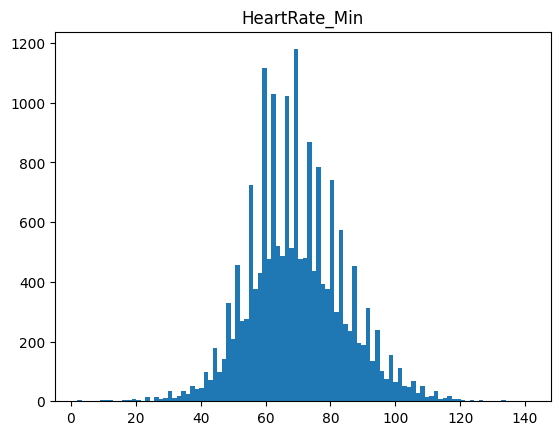

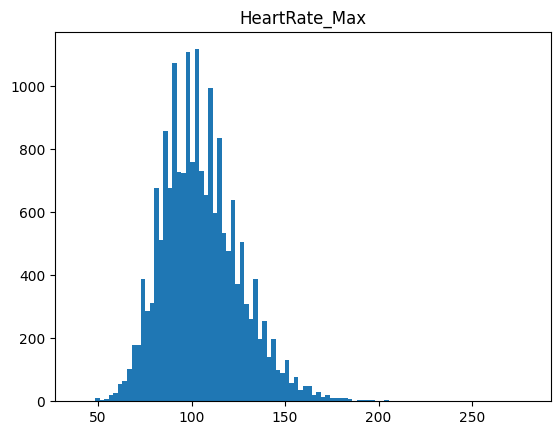

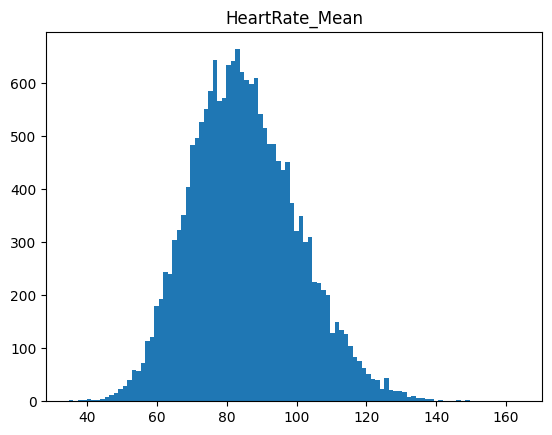

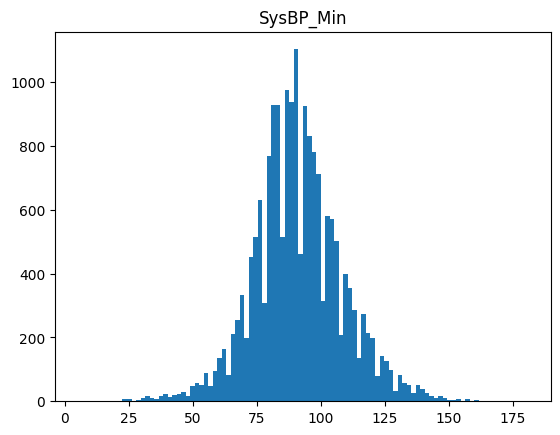

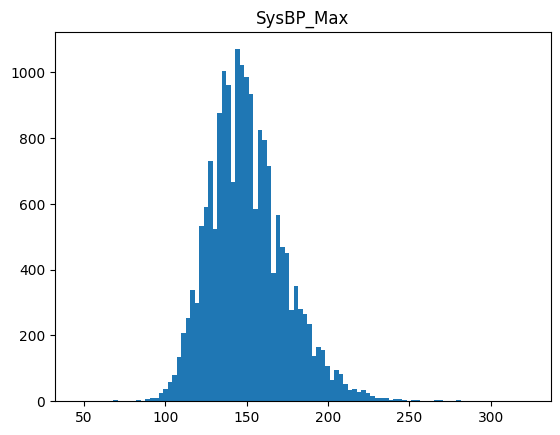

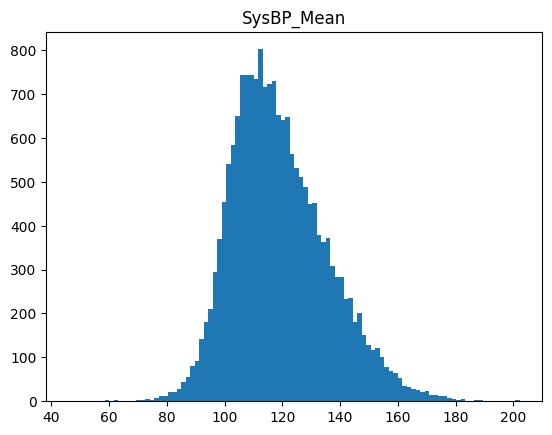

In [6]:
# Take a look at some of the numeric data.
for i in df_num.columns[4:10]:
    plt.hist(df_num[i], bins=100)
    plt.title(i)
    plt.show()

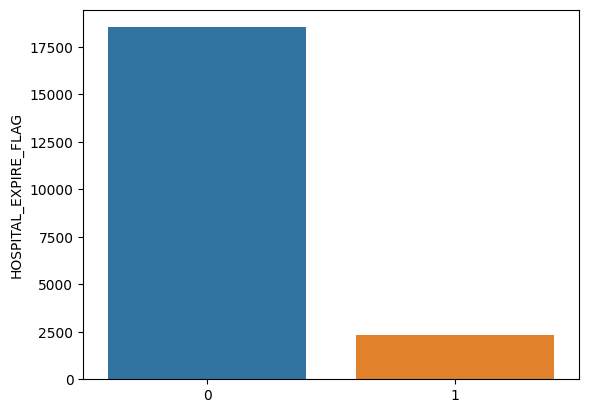

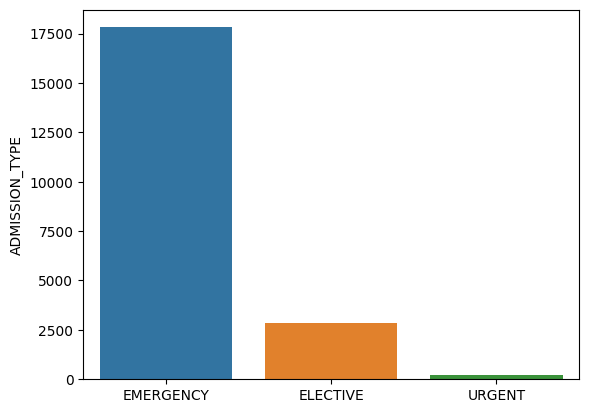

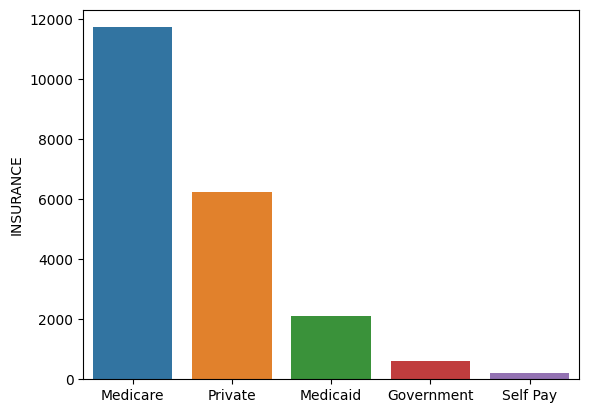

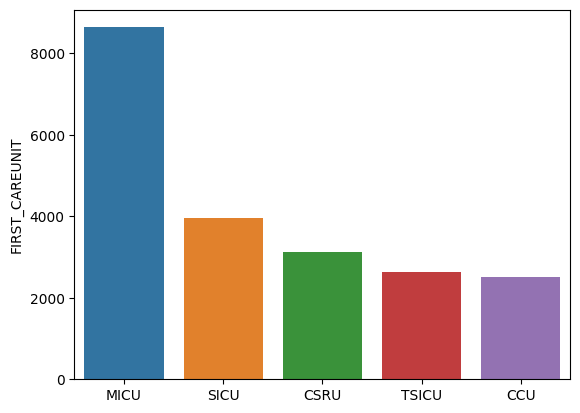

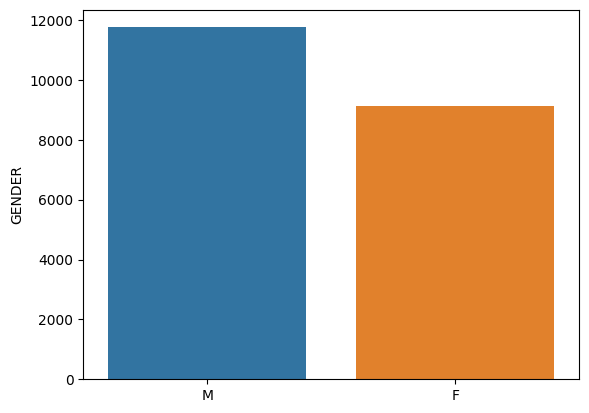

In [7]:
# Look at some of the categorical data.
for i in df_cat.columns:
    sns.barplot(x=df_cat[i].value_counts().index,y=df_cat[i].value_counts())
    plt.show()

### Marital Status - clean data

In [8]:
X_tr['MARITAL_STATUS'] = X_tr['MARITAL_STATUS'].astype(object) 
X_te['MARITAL_STATUS'] = X_te['MARITAL_STATUS'].astype(object) 

### Age

In [9]:
# Calculate ages by removing gap. Set mysterious group of '>89' patients to desired value: 'over89value'
import datetime as dt
    
def age_calc_train(X, over89value):
    # format dates into standard
    df = X
    df['DOB'] = pd.to_datetime(df['DOB']).dt.date
    df['date_of_admission'] = pd.to_datetime(df['ADMITTIME']).dt.date
    df['age'] = df.apply(lambda e: (e['date_of_admission'] - e['DOB']).days/365, axis=1)
    
    #find the edges of the "gap" between ages
    upper = []
    lower = []
    for age in df['age']:
        if age>100:
            upper.append(age)
        else:
            lower.append(age)
    u = min(upper)
    l = max(lower)
    diff = u-l
    
    cor_ages= [age-diff if age>150 else age for age in df['age']]
    df['cor_ages']=cor_ages
    
    # set special case of '>89' group (with made up birthdays) to specific value 
    mode = max(set(cor_ages), key=cor_ages.count)
    cor_ages= [over89value if age==mode else age for age in cor_ages]
    df['cor_ages']=cor_ages    
    df = df.drop(['DOB', 'date_of_admission', 'age'], axis=1)
    return df, diff

def age_calc_test(X_test, over89value, diff):
    df = X_test[['DOB', 'ADMITTIME']]
    df['DOB'] = pd.to_datetime(df['DOB']).dt.date
    df['date_of_admission'] = pd.to_datetime(df['ADMITTIME']).dt.date
    df['age'] = df.apply(lambda e: (e['date_of_admission'] - e['DOB']).days/365, axis=1)
    cor_ages= [age-diff if age>150 else age for age in df['age']]
    mode = max(set(cor_ages), key=cor_ages.count)
    cor_ages= [over89value if age==mode else age for age in cor_ages]     #shift to zame age as above
    X_te['cor_ages']=cor_ages
    return X_te

In [10]:
X_tr, dif = age_calc_train(X_tr, 92)
X_te = age_calc_test(X_te, 92, dif)

/var/folders/gs/1_v5qmgn6rv2g4xtpvbhlpgm0000gn/T/ipykernel_71999/2296589083.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DOB'] = pd.to_datetime(df['DOB']).dt.date
/var/folders/gs/1_v5qmgn6rv2g4xtpvbhlpgm0000gn/T/ipykernel_71999/2296589083.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date_of_admission'] = pd.to_datetime(df['ADMITTIME']).dt.date
/var/folders/gs/1_v5qmgn6rv2g4xtpvbhlpgm0000gn/T/ipykernel_71999/2296589083.py:37: SettingWithCopyWarning: 
A value is trying to be set on a c

In [11]:
X_tr['cor_ages'] = X_tr['cor_ages'].round(0)
X_te['cor_ages'] = X_te['cor_ages'].round(0)

In [12]:
# Also make categorical bins for ages: young, middle aged, and old.

age_bins = []
for age in X_tr['cor_ages']:
    if age<41:
        age_bins.append('<40')
    elif age <73 and age>=41:
        age_bins.append('41 - 73')
    else:
        age_bins.append('73+')
X_tr['age_bins']=age_bins

age_bins = []
for age in X_te['cor_ages']:
    if age<41:
        age_bins.append('<40')
    elif age <73 and age>=41:
        age_bins.append('41 - 73')
    else:
        age_bins.append('73+')
X_te['age_bins']=age_bins

X_tr[['HOSPITAL_EXPIRE_FLAG', 'age_bins']].groupby(['age_bins']).mean()

,HOSPITAL_EXPIRE_FLAG
age_bins,
41 - 73,0.094338
73+,0.159356
<40,0.042200


### Admission Hour

In [13]:
# What infromation does admit time have? Really, the only relevant piece of info I could find is hour.

X_tr['admit_hour'] = pd.to_datetime(X_tr['ADMITTIME']).dt.hour
late_night =[]
for i in X_tr['admit_hour']:
    if i>= 19 or i<= 3:
        late_night.append('night')
    elif i<= 8 and i>= 5:
        late_night.append('morning')
    else:
        late_night.append('day')
X_tr['late_night'] =  late_night       

X_te['admit_hour'] = pd.to_datetime(X_te['ADMITTIME']).dt.hour
late_night =[]
for i in X_te['admit_hour']:
    if i>= 19 or i<= 3:
        late_night.append('night')
    elif i<= 8 and i>= 5:
        late_night.append('morning')
    else:
        late_night.append('day')
X_te['late_night'] =  late_night  

In [14]:
X_tr[['HOSPITAL_EXPIRE_FLAG', 'late_night']].groupby(['late_night']).mean()

,HOSPITAL_EXPIRE_FLAG
late_night,
day,0.110581
morning,0.055326
night,0.135398


### Medical Data

In [15]:
# # log Transform some skewed data
# from math import log
# to_trans = ['Glucose_Mean','Glucose_Max','Glucose_Min','TempC_Max', 
#             'SysBP_Mean', 'MeanBP_Mean', 'RespRate_Max','RespRate_Mean']
# for element in to_trans:
#     X_tr[element] = np.log10(X_tr[element])
#     X_te[element] = np.log10(X_te[element])

### Diagnosis: look for keywords associated with mortality

In [16]:
# # Look for words in 'DIAGNOSIS' column that are associated with death
# # NOTE: this takes a while to run so leave it commented out. 
# # It looks through ALL of the words or phrases in all of the columns

# import re

# res = [re.split(',|-|!|;|\?|\\\\|/', i) for i in X_tr['DIAGNOSIS']]
# res
# flat_list = [item for sublist in res for item in sublist]
# flat_list.append('S/P')
# len(flat_list)

# words = []
# for word in flat_list:
#     value = X_tr['HOSPITAL_EXPIRE_FLAG'][[word in x for x in X_tr['DIAGNOSIS']]].mean()
#     hits = sum([1 if word in x else 0 for x in X_tr['DIAGNOSIS']])
#     words.append([word, value, hits])

# sorted_by_second = [tup for tup in words if tup[2] > 3 and tup[1] > .45]
# sorted_by_second = [t for t in (set(tuple(i) for i in sorted_by_second))]
# sorted_by_second = sorted(sorted_by_second, key=lambda tup: -tup[1])
# sorted_by_second    

In [17]:
# These were the top words
bad_words = ['RECURRENT LEUKEMIA','MYELOFIBROSIS','RP BLEED', 'SEPSIS', 
             'HL', 'RESPITORY FAILURE', 'PEA ARREST', 'BONE MARROW TRANSPLANT', 
             'MULTIPLE MYELOMA', 'ARREST', 'ACUTE RESPIRATORY FAILURE', 'BOWEL RESECTION', 
             'HANGING', 'CVA', 'SPINE FX', 'MALAISE', 'END STAGE LIVER FAILURE',
             'MULTITRAUMA', 'LEUKOCYTOSIS', 'ASCITES', 'EUS', 'ISCHEMIC BOWEL', 
             'MENTAL STATUS CHANGES', 'HEAD BLEED','CEREBELLAR HEMORRHAGE','SPINE FRACTURES','STOKE']

In [18]:
pattern = '|'.join(bad_words)
pattern
X_tr['bad']=[1 if row else 0 for row in X_tr.DIAGNOSIS.str.contains(pattern)]
X_te['bad']=[1 if row else 0 for row in X_te.DIAGNOSIS.str.contains(pattern)]
X_tr[['HOSPITAL_EXPIRE_FLAG', 'bad']].groupby(['bad']).mean()

,HOSPITAL_EXPIRE_FLAG
bad,
0,0.100903
1,0.303495


### Cancer: look for words in Diagnosis column associated with 'cancer' and label them

In [19]:
X_tr['HOSPITAL_EXPIRE_FLAG'][['CANCER' in str(x) or 'KEMIA' in str(x) or 'NOMA' in str(x) in x for x in X_tr['DIAGNOSIS']]].mean()
X_tr['cancer']=[1.0 if 'CANCER' in str(x) or 'KEMIA' in str(x) or 'NOMA' in str(x) else 0 for x in X_tr['DIAGNOSIS']]
X_te['cancer']=[1.0 if 'CANCER' in str(x) or 'KEMIA' in str(x) or 'NOMA' in str(x) else 0 for x in X_te['DIAGNOSIS']]
X_tr[['HOSPITAL_EXPIRE_FLAG', 'cancer']].groupby(['cancer']).mean()

,HOSPITAL_EXPIRE_FLAG
cancer,
0.0,0.110867
1.0,0.179907


### Count Comorbidities in Extra Dataset

In [20]:
# COUNT NUMBER OF COMORBIDITIES
# Training set - count comorbidities
comorb_counts = comorb.groupby('subject_id')['ICD9_CODE'].nunique()
X_tr = pd.merge(X_tr, comorb_counts, on='subject_id', how='left')
X_tr['comorb']=X_tr['ICD9_CODE'].fillna(0).astype(np.float64)   
X_tr = X_tr.drop(['ICD9_CODE'], axis = 1)

# Test set - count comorbidities
comorb_counts = comorb.groupby('subject_id')['ICD9_CODE'].nunique()
X_te = pd.merge(X_te, comorb_counts, on='subject_id', how='left')
X_te['comorb']=X_te['ICD9_CODE'].fillna(0).astype(np.float64)
X_te = X_te.drop(['ICD9_CODE'],axis=1)

X_tr[['HOSPITAL_EXPIRE_FLAG', 'comorb']].groupby(['comorb']).mean()

,HOSPITAL_EXPIRE_FLAG
comorb,
1.0,0.027027
2.0,0.017544
3.0,0.042056
4.0,0.048387
5.0,0.058233
...,...
113.0,0.000000
124.0,0.071429
130.0,0.000000


In [21]:
X_tr['comorb_lots'] = [1 if i>= 9 else 0 for i in X_tr['comorb']]
X_tr['comorb_lots'] = X_tr['comorb_lots'].astype(np.float64)
X_te['comorb_lots'] = [1 if i>= 9 else 0 for i in X_te['comorb']]
X_te['comorb_lots'] = X_te['comorb_lots'].astype(np.float64)
X_tr[['HOSPITAL_EXPIRE_FLAG', 'comorb_lots']].groupby(['comorb_lots']).mean()

,HOSPITAL_EXPIRE_FLAG
comorb_lots,
0.0,0.059719
1.0,0.122320


### Count ICU Stays

In [22]:
# Count stays by patient
subj_counts = X_tr.groupby('subject_id')['icustay_id'].nunique()
X_tr = pd.merge(X_tr, subj_counts, on='subject_id', how='left') 
subj_countse = X_te.groupby('subject_id')['icustay_id'].nunique()
X_te = pd.merge(X_te, subj_countse, on='subject_id', how='left') 

In [23]:
X_tr['multiple_icu']=[1.0 if x > 10 else 0 for x in X_tr['icustay_id_y']]
X_tr['multiple_icu'] = X_tr['multiple_icu'].astype(np.float64)
X_te['multiple_icu']=[1.0 if x > 10 else 0 for x in X_te['icustay_id_y']]
X_tr['multiple_icu'] =X_tr['multiple_icu'].astype(np.float64)
X_tr[['HOSPITAL_EXPIRE_FLAG', 'multiple_icu']].groupby(['multiple_icu']).mean()

,HOSPITAL_EXPIRE_FLAG
multiple_icu,
0.0,0.112982
1.0,0.019231


### Hospital Admissions

In [24]:
# See if its a repeat admission
X_tr['hadm_count'] = X_tr.hadm_id.map(X_tr.hadm_id.value_counts()).astype(np.float64)
X_te['hadm_count'] = X_te.hadm_id.map(X_te.hadm_id.value_counts()).astype(np.float64)

In [25]:
X_tr[['HOSPITAL_EXPIRE_FLAG', 'hadm_count']].groupby(['hadm_count']).mean().head(20)
X_tr['multiple_hadm']=[1.0 if x > 1 else 0 for x in X_tr['hadm_count']]
X_te['multiple_hadm']=[1.0 if x > 1 else 0 for x in X_te['hadm_count']]
X_tr[['HOSPITAL_EXPIRE_FLAG', 'multiple_hadm']].groupby(['multiple_hadm']).mean()

,HOSPITAL_EXPIRE_FLAG
multiple_hadm,
0.0,0.100512
1.0,0.214784


### Ethnicity - group high-risk ethnicities together in binary variable

In [26]:
X_tr['highrisk_eth']=[1.0 if str(x)=='UNKNOWN/NOT SPECIFIED' or str(x)=='AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE' or str(x)=='UNABLE TO OBTAIN' or str(x)=='MULTI RACE ETHNICITY' or str(x) =='ASIAN - CAMBODIAN' or str(x)=='ASIAN - JAPANESE' or str(x)=='ASIAN - KOREAN' else 0 for x in X_tr['ETHNICITY']]
X_te['highrisk_eth']=[1.0 if str(x)=='UNKNOWN/NOT SPECIFIED' or str(x)=='AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE' or str(x)=='UNABLE TO OBTAIN' or str(x)=='MULTI RACE ETHNICITY' or str(x) =='ASIAN - CAMBODIAN' or str(x)=='ASIAN - JAPANESE' or str(x)=='ASIAN - KOREAN' else 0 for x in X_te['ETHNICITY']]
X_tr['highrisk_eth'] = X_tr['highrisk_eth'].astype(np.float64)
X_te['highrisk_eth'] = X_te['highrisk_eth'].astype(np.float64)
X_tr[['HOSPITAL_EXPIRE_FLAG', 'highrisk_eth']].groupby(['highrisk_eth']).mean()

,HOSPITAL_EXPIRE_FLAG
highrisk_eth,
0.0,0.106449
1.0,0.206051


### Target Encode ICD9 Codes from Extra Dataset

In [27]:
X_tr = pd.merge(X_tr,comorb[['subject_id', 'ICD9_CODE']],on='subject_id',how='left')
X_te = pd.merge(X_te,comorb[['subject_id', 'ICD9_CODE']],on='subject_id',how='left')

X_tr = pd.merge(X_tr,diag,on='ICD9_CODE',how='left')
X_te = pd.merge(X_te,diag,on='ICD9_CODE',how='left')

#target encode - testing with different smoothing values shows optimal values are the ones used
from category_encoders import TargetEncoder
targ_encoder = TargetEncoder(smoothing=2, min_samples_leaf=5) #smoothing=50, min_samples_leaf=100
X_tr['target_ICD9'] = targ_encoder.fit_transform(X_tr['ICD9_CODE'], X_tr['HOSPITAL_EXPIRE_FLAG'])
X_te['target_ICD9'] = targ_encoder.transform(X_te['ICD9_CODE'])


In [28]:
X_tr['subcode'] = X_tr.ICD9_CODE.str.extract(r"([A-Z]+)")
X_tr['subcode'] = X_tr['subcode'].fillna('N')
for code in X_tr['ICD9_CODE']:
    if code.isdigit():
        c = code[:len(code)-2]
        code = c

In [29]:
X_te['subcode'] = X_te.ICD9_CODE.str.extract(r"([A-Z]+)")
X_te['subcode'] = X_te['subcode'].fillna('N')
for code in X_te['ICD9_CODE']:
    if code.isdigit():
        c = code[:len(code)-2]
        code = c

In [30]:
X_tr

,HOSPITAL_EXPIRE_FLAG,subject_id,hadm_id,icustay_id_x,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,...,icustay_id_y,multiple_icu,hadm_count,multiple_hadm,highrisk_eth,ICD9_CODE,SHORT_DIAGNOSE,LONG_DIAGNOSE,target_ICD9,subcode
0,0,55440,195768,228357,89.0,145.0,121.043478,74.0,127.0,106.586957,...,1,0.0,1.0,0.0,0.0,5789,Gastrointest hemorr NOS,"Hemorrhage of gastrointestinal tract, unspecified",0.137300,N
1,0,55440,195768,228357,89.0,145.0,121.043478,74.0,127.0,106.586957,...,1,0.0,1.0,0.0,0.0,51881,Acute respiratry failure,Acute respiratory failure,0.179244,N
2,0,55440,195768,228357,89.0,145.0,121.043478,74.0,127.0,106.586957,...,1,0.0,1.0,0.0,0.0,41071,"Subendo infarct, initial","Subendocardial infarction, initial episode of ...",0.128039,N
3,0,55440,195768,228357,89.0,145.0,121.043478,74.0,127.0,106.586957,...,1,0.0,1.0,0.0,0.0,42831,Ac diastolic hrt failure,Acute diastolic heart failure,0.096859,N
4,0,55440,195768,228357,89.0,145.0,121.043478,74.0,127.0,106.586957,...,1,0.0,1.0,0.0,0.0,42732,Atrial flutter,Atrial flutter,0.097543,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
647811,0,82638,112815,258400,59.0,97.0,77.526316,82.0,139.0,106.287671,...,1,0.0,1.0,0.0,0.0,5768,Dis of biliary tract NEC,Other specified disorders of biliary tract,0.151079,N
647812,0,82638,112815,258400,59.0,97.0,77.526316,82.0,139.0,106.287671,...,1,0.0,1.0,0.0,0.0,E8786,Abn reac-organ rem NEC,Removal of other organ (partial) (total) causi...,0.068841,E
647813,0,82638,112815,258400,59.0,97.0,77.526316,82.0,139.0,106.287671,...,1,0.0,1.0,0.0,0.0,49390,Asthma NOS,"Asthma, unspecified type, unspecified",0.062362,N
647814,0,82638,112815,258400,59.0,97.0,77.526316,82.0,139.0,106.287671,...,1,0.0,1.0,0.0,0.0,V1301,Prsnl hst urnr dsrd calc,Personal history of urinary calculi,0.075556,V


In [31]:
X_tr['shortcodes'] = X_tr['ICD9_CODE'].apply(lambda x: x[:len(x)-2] if x.isdigit() else '-1') 
X_tr['shortcodes'] = X_tr['shortcodes'].apply(lambda x: 0 if x=='' else x) 
X_tr['shortcodes'] = X_tr['shortcodes'].astype(str).astype(int)

X_tr.loc[(X_tr['shortcodes'] >= 0) & (X_tr['shortcodes'] <= 139), 'subcode'] = 'Infectious and Parasitic Diseases'
X_tr.loc[(X_tr['shortcodes'] >= 140) & (X_tr['shortcodes'] <= 239), 'subcode'] = 'Neoplasms'
X_tr.loc[(X_tr['shortcodes'] >= 240) & (X_tr['shortcodes'] <= 279), 'subcode'] = 'Endocrine, Nutritional and Metabolic Diseases, and Immunity Disorders'
X_tr.loc[(X_tr['shortcodes'] >= 280) & (X_tr['shortcodes'] <= 289), 'subcode'] = 'Diseases of the Blood and Blood-forming Organs'
X_tr.loc[(X_tr['shortcodes'] >= 290) & (X_tr['shortcodes'] <= 319), 'subcode'] = 'Mental Disorders'
X_tr.loc[(X_tr['shortcodes'] >= 320) & (X_tr['shortcodes'] <= 389), 'subcode'] = 'Diseases of the Nervous System and Sense Organs'
X_tr.loc[(X_tr['shortcodes'] >= 390) & (X_tr['shortcodes'] <= 459), 'subcode'] = 'Diseases of the Circulatory System'
X_tr.loc[(X_tr['shortcodes'] >= 460) & (X_tr['shortcodes'] <= 519), 'subcode'] = 'Diseases of the Respiratory System'
X_tr.loc[(X_tr['shortcodes'] >= 520) & (X_tr['shortcodes'] <= 579), 'subcode'] = 'Diseases of the Digestive System'
X_tr.loc[(X_tr['shortcodes'] >= 580) & (X_tr['shortcodes'] <= 629), 'subcode'] = 'Diseases of the Genitourinary System'
X_tr.loc[(X_tr['shortcodes'] >= 630) & (X_tr['shortcodes'] <= 679), 'subcode'] = 'Complications of Pregnancy, Childbirth, and the Puerperium'
X_tr.loc[(X_tr['shortcodes'] >= 680) & (X_tr['shortcodes'] <= 709), 'subcode'] = 'Diseases of the Skin and Subcutaneous Tissue'
X_tr.loc[(X_tr['shortcodes'] >= 710) & (X_tr['shortcodes'] <= 739), 'subcode'] = 'Diseases of the Musculoskeletal System and Connective Tissue'
X_tr.loc[(X_tr['shortcodes'] >= 740) & (X_tr['shortcodes'] <= 759), 'subcode'] = 'Congenital Anomalies'
X_tr.loc[(X_tr['shortcodes'] >= 760) & (X_tr['shortcodes'] <= 779), 'subcode'] = 'Certain Conditions originating in the Perinatal Period'
X_tr.loc[(X_tr['shortcodes'] >= 780) & (X_tr['shortcodes'] <= 799), 'subcode'] = 'Symptoms, Signs and Ill-defined Conditions'
X_tr.loc[(X_tr['shortcodes'] >= 800) & (X_tr['shortcodes'] <= 999), 'subcode'] = 'Injury and Poisoning'
X_tr.loc[(X_tr['subcode'] == 'E'), 'subcode'] = 'Supplementary Classification of External Causes of Injury and Poisoning'
X_tr.loc[(X_tr['subcode'] == 'V'), 'subcode'] = 'Supplementary Classification of Factors influencing Health Status and Contact with Health Services'

In [32]:
X_te['shortcodes'] = X_te['ICD9_CODE'].apply(lambda x: x[:len(x)-2] if x.isdigit() else '-1') 
X_te['shortcodes'] = X_te['shortcodes'].apply(lambda x: 0 if x=='' else x) 
X_te['shortcodes'] = X_te['shortcodes'].astype(str).astype(int)

X_te.loc[(X_te['shortcodes'] >= 0) & (X_te['shortcodes'] <= 139), 'subcode'] = 'Infectious and Parasitic Diseases'
X_te.loc[(X_te['shortcodes'] >= 140) & (X_te['shortcodes'] <= 239), 'subcode'] = 'Neoplasms'
X_te.loc[(X_te['shortcodes'] >= 240) & (X_te['shortcodes'] <= 279), 'subcode'] = 'Endocrine, Nutritional and Metabolic Diseases, and Immunity Disorders'
X_te.loc[(X_te['shortcodes'] >= 280) & (X_te['shortcodes'] <= 289), 'subcode'] = 'Diseases of the Blood and Blood-forming Organs'
X_te.loc[(X_te['shortcodes'] >= 290) & (X_te['shortcodes'] <= 319), 'subcode'] = 'Mental Disorders'
X_te.loc[(X_te['shortcodes'] >= 320) & (X_te['shortcodes'] <= 389), 'subcode'] = 'Diseases of the Nervous System and Sense Organs'
X_te.loc[(X_te['shortcodes'] >= 390) & (X_te['shortcodes'] <= 459), 'subcode'] = 'Diseases of the Circulatory System'
X_te.loc[(X_te['shortcodes'] >= 460) & (X_te['shortcodes'] <= 519), 'subcode'] = 'Diseases of the Respiratory System'
X_te.loc[(X_te['shortcodes'] >= 520) & (X_te['shortcodes'] <= 579), 'subcode'] = 'Diseases of the Digestive System'
X_te.loc[(X_te['shortcodes'] >= 580) & (X_te['shortcodes'] <= 629), 'subcode'] = 'Diseases of the Genitourinary System'
X_te.loc[(X_te['shortcodes'] >= 630) & (X_te['shortcodes'] <= 679), 'subcode'] = 'Complications of Pregnancy, Childbirth, and the Puerperium'
X_te.loc[(X_te['shortcodes'] >= 680) & (X_te['shortcodes'] <= 709), 'subcode'] = 'Diseases of the Skin and Subcutaneous Tissue'
X_te.loc[(X_te['shortcodes'] >= 710) & (X_te['shortcodes'] <= 739), 'subcode'] = 'Diseases of the Musculoskeletal System and Connective Tissue'
X_te.loc[(X_te['shortcodes'] >= 740) & (X_te['shortcodes'] <= 759), 'subcode'] = 'Congenital Anomalies'
X_te.loc[(X_te['shortcodes'] >= 760) & (X_te['shortcodes'] <= 779), 'subcode'] = 'Certain Conditions originating in the Perinatal Period'
X_te.loc[(X_te['shortcodes'] >= 780) & (X_te['shortcodes'] <= 799), 'subcode'] = 'Symptoms, Signs and Ill-defined Conditions'
X_te.loc[(X_te['shortcodes'] >= 800) & (X_te['shortcodes'] <= 999), 'subcode'] = 'Injury and Poisoning'
X_te.loc[(X_te['subcode'] == 'E'), 'subcode'] = 'Supplementary Classification of External Causes of Injury and Poisoning'
X_te.loc[(X_te['subcode'] == 'V'), 'subcode'] = 'Supplementary Classification of Factors influencing Health Status and Contact with Health Services'

In [33]:
targ_encoder = TargetEncoder(smoothing=10, min_samples_leaf=10)
X_tr['ICD9_target_cat']  = targ_encoder.fit_transform(X_tr['subcode'], X_tr['HOSPITAL_EXPIRE_FLAG'])
X_te['ICD9_target_cat']  = targ_encoder.transform(X_te['subcode'])

X_tr['LONG_DIAGNOSE'] = X_tr['LONG_DIAGNOSE'].astype(object)

In [34]:
# Redefine shortcodes to include V and E categories
X_tr['shortcodes'] = X_tr['ICD9_CODE'].apply(lambda x: x[:len(x)-2])
X_tr['shortcodes'] = X_tr['ICD9_CODE'].apply(lambda x: x[:len(x)-2])

In [35]:
X_tr['shortcodes'] = X_tr['shortcodes'].astype(object)
X_te['shortcodes'] = X_te['shortcodes'].astype(object)

targ_encoder = TargetEncoder(smoothing=2, min_samples_leaf=5)
X_tr['shortcodes_target']  = targ_encoder.fit_transform(X_tr['shortcodes'], X_tr['HOSPITAL_EXPIRE_FLAG'])
X_te['shortcodes_target']  = targ_encoder.transform(X_te['shortcodes'])

In [36]:
class AttributesAdder():
    def transform(self, X):
        X['max_ICD9_target'] = X.groupby(['subject_id'])['target_ICD9'].transform(max).astype(np.float64)   
        X['mean_ICD9_target'] = X.groupby(['subject_id'])['target_ICD9'].transform('mean').astype(np.float64)   
        X['min_ICD9_target'] = X.groupby(['subject_id'])['target_ICD9'].transform(min).astype(np.float64)   
        X['med_ICD9_target'] = X.groupby(['subject_id'])['target_ICD9'].transform('median').astype(np.float64) 
        #X['std_ICD9_target'] = X.groupby(['subject_id'])['target_ICD9'].transform('std').astype(np.float64)
        X['bad'] = X.groupby(['subject_id'])['bad'].transform('max').astype(np.float64)
        #X['max_ICD9_target_cat'] = X.groupby(['subject_id'])['target_ICD9'].transform(max).astype(np.float64)   
        X['mean_ICD9_target_cat'] = X.groupby(['subject_id'])['ICD9_target_cat'].transform('mean').astype(np.float64)
        X['mean_shortcodes_target'] = X.groupby(['subject_id'])['shortcodes_target'].transform('mean').astype(np.float64)

class AttributesRemover():
    def transform(self, X):
        cols = list(X.columns)
        cols.remove('ICD9_CODE')
        cols.remove('target_ICD9')
        cols.remove('subcode')
        cols.remove('ICD9_target_cat')
        cols.remove('shortcodes')
        cols.remove('shortcodes_target')
        cols.remove('LONG_DIAGNOSE')
        cols.remove('SHORT_DIAGNOSE')
        X = X[cols]
        
        X = X.drop_duplicates(keep="first", inplace=False)
        X = X.reset_index() 
        return X

In [37]:
obj1 = AttributesAdder()
obj2 = AttributesRemover()
obj1.transform(X_tr)
obj1.transform(X_te)

In [38]:
X_tr =obj2.transform(X_tr)
X_te =obj2.transform(X_te)

### 'all' and 'mtsq' - other relevant variables

In [39]:
# Make a new variable that is the square of the mean of the target encoded comorbidities
X_tr['mtsq'] = [val*val for val in X_tr['mean_ICD9_target']]
X_te['mtsq'] = [val*val for val in X_te['mean_ICD9_target']]

# Create that is the sum of all the target variables.
X_tr['all'] = X_tr['comorb']*X_tr['mean_ICD9_target']
X_te['all'] = X_te['comorb']*X_te['mean_ICD9_target']

# 3. Trim Down Dataset

Not all of our features will be valuable to our model. Here we will begin cutting down some features that have proven to harm our auc scores.

In [40]:
# Just to make sure things line up.
y_tr = X_tr['HOSPITAL_EXPIRE_FLAG']

In [41]:
to_encode = ['ADMISSION_TYPE',
             'late_night',
             'age_bins',
             #'ICD9_diagnosis', added manually since different target encoding#<- removing this does NOT help A LOT
            #'admit_hour',  #<- removing this helps a tinny bit
            #'DIAGNOSIS',#  added manuall since different target encoding <- removing this does NOT help
             'ETHNICITY', # <-- removing this does NOT help
             'RELIGION',
             'INSURANCE', 
             'FIRST_CAREUNIT',
             'MARITAL_STATUS',
             'GENDER'
            ] 

col = list(X_tr.select_dtypes('float64').columns)
diff_te =['DIAGNOSIS', 'ICD9_diagnosis']
X_tr = X_tr[col+to_encode+diff_te]
X_te = X_te[col+to_encode+diff_te]

In [42]:
X_train_all = X_tr
X_test_all = X_te

In [44]:
def col_dropper(X, li):
    for cols in li:
        X = X.drop([cols], axis=1)
    return X
        
list_cols_to_drop = ['highrisk_eth', #'cor_ages',
                    'HeartRate_Min','MeanBP_Max', 'cancer', 
                    'DiasBP_Max', 'SysBP_Max','TempC_Max', 'bad',
                    'SpO2_Max', 'DiasBP_Mean','Glucose_Min', #'std_ICD9_target',
                    'RespRate_Min','Glucose_Max'
                    ]

# Some notes regarding the columns that I should and shouldn't drop from my model.

# cols that DEF help: 'hadm_count'  'all'

# Cols that maybe help: 'mean_ICD9_target' 'multiple_hadm' 'late_night',  
# 'comorb'??? 'multiple_icu' 'mean_ICD9_target_cat' 'highrisk_eth'??neutral?  'comorb_lots'

# cols that maybe don't help: 'bad' 'cancer', 'admit_hour' <- in to_encode

# # Manually drop some columns
# X_tr = col_dropper(X_train_all, list_cols_to_drop)
# X_te = col_dropper(X_test_all, list_cols_to_drop)
                   
all_cols = len(X_tr.columns)

# 4. knn Pipeline

In [45]:
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.ensemble import BaggingClassifier
from sklearn.feature_selection import SelectKBest, SelectFromModel, f_classif

preprocessor = ColumnTransformer(
    transformers=[
        
        ('target encoder icd9', TargetEncoder(smoothing=2, min_samples_leaf=5), ['DIAGNOSIS','ICD9_diagnosis']),
        ('target encoder', TargetEncoder(smoothing=20, min_samples_leaf=30), to_encode) 
    ], remainder='passthrough'
)

pipeline = Pipeline([
                    ('preprocess', preprocessor),
                    ('scale', StandardScaler()),
                    ('impute', SimpleImputer()),
                    ('random_under_sampler', RandomUnderSampler(random_state=42, replacement=True)),
                    ('skb', SelectKBest(f_classif)),
                    ('knn', KNeighborsClassifier(algorithm='brute',
                                            weights='distance', 
                                            metric='minkowski')),
                  ])

So this pipeline is doing many things for us. First it target encodes various columns (this is done within the cross-validation step so it helps avoid overtraining). Then we scale and impute. 

Then, to help with our skewed data, we added a random undersampler, which usually picked scores of around .6 (this is the ratio between the samples in the min class and the number in the (re)sampled maj class). Without the random undersampler, this ratio would be around .12. 

Next, we get rid of some extra variables using SelectKBest. The model generally likes to pick around 30-40 variables.
Finally, the KNN model. Here I have found brute to be optimal since we are shooting for a high score after all. Distance weights are shown to be better overall. Manhattan distances seem to work better for us here (p=1) but I must confess that I don't have an intuitive explanation as to why; the score was simply higher. And then, of course, a value of 200-400 neighbors proved optimal. This makes sense considering we have a dataset of 20k samples, so a few hundred neighbors would provide a good balance of flexibility and robustness.

In [46]:
pipeline

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('target encoder icd9',
                                                  TargetEncoder(min_samples_leaf=5,
                                                                smoothing=2),
                                                  ['DIAGNOSIS',
                                                   'ICD9_diagnosis']),
                                                 ('target encoder',
                                                  TargetEncoder(min_samples_leaf=30,
                                                                smoothing=20),
                                                  ['ADMISSION_TYPE',
                                                   'late_night', 'age_bins',
                                                   'ETHNICITY', 'RELIGION',
                                                   'INSURANCE',
                                                   'FIRST_CAREUNIT',
                                                   'MARITAL_STATUS',
                                                   'GENDER'])])),
                ('scale', StandardScaler()), ('impute', SimpleImputer()),
                ('random_under_sampler',
                 RandomUnderSampler(random_state=42, replacement=True)),
                ('skb', SelectKBest()),
                ('knn',
                 KNeighborsClassifier(algorithm='brute', weights='distance'))])

In [47]:
def fit_and_print(p, X_tr=X_tr, y_tr=y_tr, X_te=X_te):

    # define the parameter grid    
    param_grid = {
        'impute__strategy':['mean'],#,'median'],
        'knn__n_neighbors': [200],
        'knn__p':[1],
        'random_under_sampler__sampling_strategy': [.575,.6, 1],
        'random_under_sampler__shrinkage': [.5, 0]
    }

    # run a grid search to calculate the cross-validation
    # accuracy associated to each parameter combination
    clf = GridSearchCV(
        estimator=p,
        scoring = 'roc_auc',
        param_grid=param_grid,
        cv=StratifiedKFold(n_splits=100),
        n_jobs=-1
    )

    # Fit model
    clf.fit(X_tr, y_tr)
    
    # Prep output
    res = pd.DataFrame(clf.cv_results_)
    res = res.rename(columns={
        'param_random_under_sampler__sampling_strategy': 'under sampler',
        'param_impute__strategy':'imputer',
        'param_knn__n_neighbors':'k',
        'param_knn__p':'p',
        'param_skb__k': 'skb_k',
        'mean_test_score': 'AUC Score:'})
    res = res[['AUC Score:', 
               'imputer',
               'k',
               'p',
               'skb_k',
               'under sampler'
              ]].sort_values('AUC Score:', ascending=False)
    print(res)
    return clf

In [48]:
best_model = fit_and_print(pipeline, X_tr=X_tr, y_tr=y_tr, X_te= X_te)

ValueError: Invalid parameter 'shrinkage' for estimator RandomUnderSampler(random_state=42, replacement=True, sampling_strategy=0.575). Valid parameters are: ['random_state', 'replacement', 'sampling_strategy'].

In [ ]:
# For knn
a = best_model.predict_proba(X_te)
b = [a[i,1] for i in range(len(a))]

In [ ]:
# # For computing out-of-sample AUC score if test/train split was done at the beginning.
# from sklearn import metrics
# y_pred = np.array(b)
# fpr, tpr, thresholds = metrics.roc_curve(y_te, y_pred, pos_label=1)
# auc = round(metrics.auc(fpr, tpr),4)
# auc

In [ ]:
# Export data
outputv = pd.DataFrame({
    "icustay_id": val['icustay_id'], 
    "HOSPITAL_EXPIRE_FLAG": b})

outputv.to_csv('outputk_pred.csv', index=False)

In [ ]:
# Here I attempted to run a knn pipeline with Bagginging but I couldn't get it to give 
# me a higher score than my simple knn model. Not really sure what was wrong...
# NOTE: This takes a few hours to run.
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.ensemble import BaggingClassifier
from sklearn.feature_selection import SelectKBest, SelectFromModel, f_classif

preprocessor = ColumnTransformer(
    transformers=[
         ('target encoder icd9', TargetEncoder(smoothing=2, min_samples_leaf=5), ['DIAGNOSIS','ICD9_diagnosis']),
        ('target encoder', TargetEncoder(smoothing=20, min_samples_leaf=30), to_encode) 
    ], remainder='passthrough'
)

knn_pipe = Pipeline([
     ('knn', KNeighborsClassifier(algorithm='brute',
                                            weights='distance', 
                                            metric='minkowski')),
])

pipeline = Pipeline([
                    ('preprocess', preprocessor),
                    ('scale', StandardScaler()),
                    ('impute', SimpleImputer()),
                    ('random_under_sampler', RandomUnderSampler(random_state=42, replacement=True)),
                    ('skb', SelectKBest(f_classif)),
                    ('bag', BaggingClassifier(knn_pipe)),
                  ])

In [49]:
def fit_and_print(p, X_tr=X_tr, y_tr=y_tr, X_te=X_te):

    # define the parameter grid    
    param_grid = {
        'impute__strategy':['mean'],
        'bag__bootstrap_features' : [True],
        'bag__n_estimators':[100],
        'bag__base_estimator__knn__n_neighbors': [100],
        'bag__base_estimator__knn__p':[1],
        'skb__k': [30],
        'random_under_sampler__sampling_strategy': [0.5, 0.55]
    }

    # run a grid search to calculate the cross-validation
    # accuracy associated to each parameter combination
    clf = GridSearchCV(
        estimator=p,
        scoring = 'roc_auc',
        param_grid=param_grid,
        cv=StratifiedKFold(n_splits=20),
        n_jobs=-1
    )

    # Fit model
    clf.fit(X_tr, y_tr)
    
    # Prep output
    res = pd.DataFrame(clf.cv_results_)
    res = res.rename(columns={
        'param_random_under_sampler__sampling_strategy': 'random_under_sampler_strategy',
        'param_impute__strategy':'imputer',
        'param_bag__bootstrap_features' : 'boot_feat',
        'param_bag__base_estimator__knn__n_neighbors': 'knn k',
        'param_bag__base_estimator__knn__p':'knn p',
        'param_bag__n_estimators':'bag n',
        'param_skb__k': 'skb k',
        'mean_test_score': 'AUC Score:'})
    res = res[['AUC Score:', 
               'imputer',
               'knn k',
               'bag n',
               'knn p',
               'boot_feat',
               'skb k',
               'random_under_sampler_strategy'
              ]].sort_values('AUC Score:', ascending=False)
    print(res)
    return clf

In [ ]:
# best_model = fit_and_print(pipeline, X_tr=X_tr, y_tr=y_tr, X_te= X_te) 

In [ ]:
# # For Bagging
# a = best_model.predict(X_te)

In [ ]:
# from sklearn import metrics
# y_pred = np.array(a)
# fpr, tpr, thresholds = metrics.roc_curve(y_te, y_pred, pos_label=1)
# auc = round(metrics.auc(fpr, tpr),4)
# auc

# SVM

In [66]:
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC 

preprocessor = ColumnTransformer(
    transformers=[ 
        ('target encoder icd9', TargetEncoder(smoothing=2, min_samples_leaf=5), ['DIAGNOSIS','ICD9_diagnosis']),
        ('target encoder', TargetEncoder(smoothing=20, min_samples_leaf=30), to_encode) 
    ], remainder='passthrough'
)

pipelinesvm = Pipeline([#('ages', ac),
                    ('preprocess', preprocessor),
                    ('scale', StandardScaler()),
                    ('impute', SimpleImputer()),
                    #('smote', SMOTE(random_state=42)),
                    #('random_under_sampler', RandomUnderSampler(random_state=42, replacement=True)),
                    ('skb', SelectKBest(f_classif)),
                    ('svc', SVC(class_weight = 'balanced', probability=True)),
                  ])

The pipeline below does many of the same things our other pipeline does except in this one I included SMOTE and the svm of course.

SMOTE generates synthetic data from the minority class, so combined with random undersampler, this completely changes the balance of the data, giving our minority class a much larger presence. That explains why the random under sampler values were lower (around .48 compared to .60 above). A good SMOTE value turned out to be around .18, giving our data an balance similar to that in our knn model.

For the SVM, the model picked a relatively mild penalty of C = 1.25 giving us a good amount of flexibility. The best kernel was 'rbf', which allows for much more complicated mathematical abstractions than 'linear' (which means better divisions between data points.) Finally, a small value of gamma = 0.007, meaning a single example's influence reaches relatively far. 

In [51]:
pipelinesvm

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('target encoder icd9',
                                                  TargetEncoder(min_samples_leaf=5,
                                                                smoothing=2),
                                                  ['DIAGNOSIS',
                                                   'ICD9_diagnosis']),
                                                 ('target encoder',
                                                  TargetEncoder(min_samples_leaf=30,
                                                                smoothing=20),
                                                  ['ADMISSION_TYPE',
                                                   'late_night', 'age_bins',
                                                   'ETHNICITY', 'RELIGION',
                                                   'INSURANCE',
                                                   'FIRST_CAREUNIT',
                                                   'MARITAL_STATUS',
                                                   'GENDER'])])),
                ('scale', StandardScaler()), ('impute', SimpleImputer()),
                ('skb', SelectKBest()), ('svc', SVC(class_weight='balanced'))])

In [67]:
def fit_and_printsvm(p, X_tr=X_tr, y_tr=y_tr, X_te=X_te):

    # define the parameter grid    
    param_grid = {
        'impute__strategy':['mean'],
        'svc__kernel': ['rbf'],#,'linear'],
        'svc__C':[1.25], 
        'skb__k': [39],#all_cols
        'svc__gamma':[0.007],
        #'smote__sampling_strategy': [.18],
        #'random_under_sampler__sampling_strategy': [0.46]
    }

    # run a grid search to calculate the cross-validation
    # accuracy associated to each parameter combination
    clf = GridSearchCV(
        estimator=p,
        scoring = 'roc_auc',
        param_grid=param_grid,
        cv=StratifiedKFold(n_splits=10),
        n_jobs=-1
    )

    # Fit model
    clf.fit(X_tr, y_tr)
    
    # Prep output
    res = pd.DataFrame(clf.cv_results_)
    res = res.rename(columns={
        #'param_smote__sampling_strategy': 'smote',
        #'param_random_under_sampler__sampling_strategy': 'under_sampler',
        'param_impute__strategy':'imputer',
        'param_svc__C':'C',
        'param_skb__k': 'skb k',
        'param_svc__gamma':'gamma',
        'param_svc__kernel':'kernel',
        #'feature_selection__C':'C',
        'mean_test_score': 'AUC Score:'
    })
    res = res[['AUC Score:', 'imputer',
               'gamma',
               'kernel',
               'skb k',
               #'smote',
               'C',
               #'under_sampler'
              ]].sort_values('AUC Score:', ascending=False)
    print(res)
    return clf

In [68]:
svm_best_model = fit_and_printsvm(pipelinesvm, X_tr=X_tr, y_tr=y_tr, X_te= X_te)

   AUC Score: imputer  gamma kernel skb k     C
0    0.938919    mean  0.007    rbf    39  1.25


In [69]:
# SECOND BEST: 0.91425
#      AUC Score: imputer  gamma kernel skb k smote     C under_sampler
# 44     0.940583    mean  0.007    rbf    52  0.18  1.25          0.46

# MY TOP SCORE on kaggle: 0.91484

# AUC Score: imputer  gamma kernel  skb k    smote      C       under_sampler
# 0.939794    mean   0.01    rbf    35         0.18   1.25          0.47



# 44     0.940583    mean  0.007    rbf    52  0.18  1.25          0.46
# 46     0.940574    mean  0.007    rbf    52  0.18   1.5          0.46
# 42     0.940565    mean  0.007    rbf    52  0.18  1.15          0.46
# 48     0.940466    mean  0.007    rbf    52   0.2  1.15          0.46
# 50     0.940466    mean  0.007    rbf    52   0.2  1.25          0.46
# ..          ...     ...    ...    ...   ...   ...   ...           ...
# 95     0.939247    mean   0.01    rbf    52  0.16   1.5          0.48
# 103    0.939240    mean   0.01    rbf    52   0.2  1.15          0.48
# 105    0.939119    mean   0.01    rbf    52   0.2  1.25          0.48
# 53     0.938924    mean   0.01    rbf    52   0.2   1.5          0.46
# 107    0.938795    mean   0.01    rbf    52   0.2   1.5          0.48

In [71]:
# For svm
av = svm_best_model.predict_proba(X_te)
bv = [av[i,1] for i in range(len(av))]

In [5525]:
outputv = pd.DataFrame({
    "icustay_id": val['icustay_id'], 
    "HOSPITAL_EXPIRE_FLAG": bv})

outputv.to_csv('outputv_pred.csv', index=False)

# BONUS: Export Model for Random Forest

In [55]:

# Save Model Using Pickle
from sklearn import model_selection
import pickle

In [54]:
# import sys
# !{sys.executable} -m pip install pickle

ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle


In [57]:
# save the model to disk
filename = 'deathpredict.sav'
pickle.dump(svm_best_model, open(filename, 'wb'))

In [78]:
X_tr

,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,...,late_night,age_bins,ETHNICITY,RELIGION,INSURANCE,FIRST_CAREUNIT,MARITAL_STATUS,GENDER,DIAGNOSIS,ICD9_diagnosis
0,89.0,145.0,121.043478,74.0,127.0,106.586957,42.0,90.0,61.173913,59.0,...,day,41 - 73,WHITE,PROTESTANT QUAKER,Medicare,MICU,SINGLE,F,GASTROINTESTINAL BLEED,5789
1,63.0,110.0,79.117647,89.0,121.0,106.733333,49.0,74.0,64.733333,58.0,...,night,41 - 73,WHITE,UNOBTAINABLE,Private,MICU,MARRIED,F,ESOPHAGEAL FOOD IMPACTION,53013
2,81.0,98.0,91.689655,88.0,138.0,112.785714,45.0,67.0,56.821429,64.0,...,night,41 - 73,BLACK/AFRICAN AMERICAN,PROTESTANT QUAKER,Medicare,MICU,SEPARATED,F,UPPER GI BLEED,56983
3,76.0,128.0,98.857143,84.0,135.0,106.972973,30.0,89.0,41.864865,48.0,...,morning,73+,WHITE,NOT SPECIFIED,Medicare,SICU,WIDOWED,F,HIATAL HERNIA/SDA,5533
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,night,73+,WHITE,JEWISH,Medicare,TSICU,WIDOWED,F,ABDOMINAL PAIN,56211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20880,65.0,92.0,78.500000,60.0,160.0,110.976190,34.0,94.0,56.595238,41.0,...,morning,73+,WHITE,CATHOLIC,Medicare,MICU,MARRIED,M,ALTERED MENTAL STATUS,3229
20881,74.0,112.0,89.156250,100.0,150.0,123.272727,58.0,83.0,67.818182,74.0,...,night,41 - 73,BLACK/HAITIAN,NOT SPECIFIED,Private,SICU,MARRIED,M,NEW BRAIN MASS,1918
20882,58.0,97.0,76.933333,94.0,131.0,112.037037,55.0,83.0,67.370370,66.0,...,day,41 - 73,BLACK/AFRICAN AMERICAN,PROTESTANT QUAKER,Private,MICU,DIVORCED,F,HYPOGLYCEMIA,24980
20883,59.0,102.0,81.844444,96.0,150.0,123.837209,47.0,85.0,60.232558,65.0,...,night,73+,WHITE,PROTESTANT QUAKER,Medicare,CCU,WIDOWED,F,CORONARY ARTERY DISEASE\PERCUTANEOUS CORONARY ...,41401


In [93]:
## Save csv directly and import. training
avt = svm_best_model.predict_proba(X_tr)
bvt = [avt[i,1] for i in range(len(avt))]

outputv = pd.DataFrame({
    "icustay_id": training['icustay_id'], 
    "pred_death": bvt})

outputv.to_csv('svm_deathpred.csv', index=False)

In [95]:
## Save csv directly and import. testing
avt = svm_best_model.predict_proba(X_te)
bvt = [avt[i,1] for i in range(len(avt))]

outputv = pd.DataFrame({
    "icustay_id": val['icustay_id'], 
    "pred_death": bvt})

outputv.to_csv('svm_deathpred_te.csv', index=False)

In [92]:
dif = outputv['actual']-outputv['pred_death']
sq = [x**2 for x in dif]
sum(sq)**0.5/len(sq)

0.0014955112778581453